In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import load_cora
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/sameenahmad/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_classes = 7
data, cora_text = load_cora.get_raw_text_cora(use_text=True)
cora_labels = data.y.to(device)

In [3]:
model_name = 'bert-base-uncased'
tokeniser = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name, output_hidden_states=True).to(device)
for param in bert_model.parameters():
    param.requires_grad = False

In [4]:
tokens = tokeniser(cora_text, return_tensors='pt', padding=True, truncation=True, max_length=512)
tokens = {k: v.to(device) for k, v in tokens.items()} 

class TokenDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.tokens['input_ids'])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokens.items()}, self.labels[idx]
dataset = TokenDataset(tokens, cora_labels)

In [5]:
class HiddenDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


def get_hidden(layer, batch_size = 128):
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch_tokens, batch_labels in DataLoader(dataset, batch_size=batch_size, shuffle=False):
            outputs = bert_model(**batch_tokens)
            embeddings = outputs.hidden_states[layer][:, 0, :]
            all_embeddings.append(embeddings)
            all_labels.append(batch_labels)
    
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_embeddings, all_labels


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(768, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_embedding(self, x):
        x = torch.relu(self.fc1(x))
        return x

In [7]:
def get_embeddings(layer, epochs = 100, verbose = False):
    print(f'Starting precomputing embeddings for layer {layer}')
    hidden_dataset = HiddenDataset(*get_hidden(layer))
    print(f'Finished precomputing embeddings for layer {layer}')
    train_size = int(0.9 * len(hidden_dataset))
    test_size = len(hidden_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(hidden_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_embeddings, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()
            train_loss += loss.item()
        
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for batch_embeddings, batch_labels in test_loader:
                outputs = model(batch_embeddings)
                loss = criterion(outputs, batch_labels)

                _, predicted = torch.max(outputs, 1)
                test_total += batch_labels.size(0)
                test_correct += (predicted == batch_labels).sum().item()
                test_loss += loss.item()
        
        if verbose:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/train_total}, Train Accuracy: {train_correct/train_total}, Test Loss: {test_loss/test_total}, Test Accuracy: {test_correct/test_total}')

    embeddings = []
    labels = []

    with torch.no_grad():
        for batch_embeddings, batch_labels in DataLoader(hidden_dataset, batch_size=128, shuffle=False):
            embeddings.append(model.get_embedding(batch_embeddings))
            labels.append(batch_labels)
        
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels, test_correct/test_total

In [8]:
layer_embeddings = {}
for layer in [3, 6, 9, 12]:
    embeddings, labels, accuracy = get_embeddings(layer, epochs=100, verbose=True)
    layer_embeddings[layer] = embeddings, labels, accuracy

Starting precomputing embeddings for layer 3
Finished precomputing embeddings for layer 3
Epoch 1/100, Train Loss: 0.015199167199148524, Train Accuracy: 0.29421419778416086, Test Loss: 0.019776119077337624, Test Accuracy: 0.2915129151291513
Epoch 2/100, Train Loss: 0.014974843638814959, Train Accuracy: 0.30324169060320066, Test Loss: 0.01970055974277623, Test Accuracy: 0.2915129151291513
Epoch 3/100, Train Loss: 0.015117261465524228, Train Accuracy: 0.30324169060320066, Test Loss: 0.019542115640816215, Test Accuracy: 0.2915129151291513
Epoch 4/100, Train Loss: 0.014879398136585033, Train Accuracy: 0.30324169060320066, Test Loss: 0.019555068543916258, Test Accuracy: 0.2915129151291513
Epoch 5/100, Train Loss: 0.014703546677841043, Train Accuracy: 0.30324169060320066, Test Loss: 0.019337292526920784, Test Accuracy: 0.2915129151291513
Epoch 6/100, Train Loss: 0.014669627746109304, Train Accuracy: 0.30324169060320066, Test Loss: 0.019232509760839032, Test Accuracy: 0.2915129151291513
Epoch

In [9]:
TSNE_embeddings = {}
for layer, (embeddings, labels, accuracy) in layer_embeddings.items():
    TSNE_embeddings[layer] = TSNE(n_components=2).fit_transform(embeddings.cpu().numpy()), labels.cpu().numpy(), accuracy

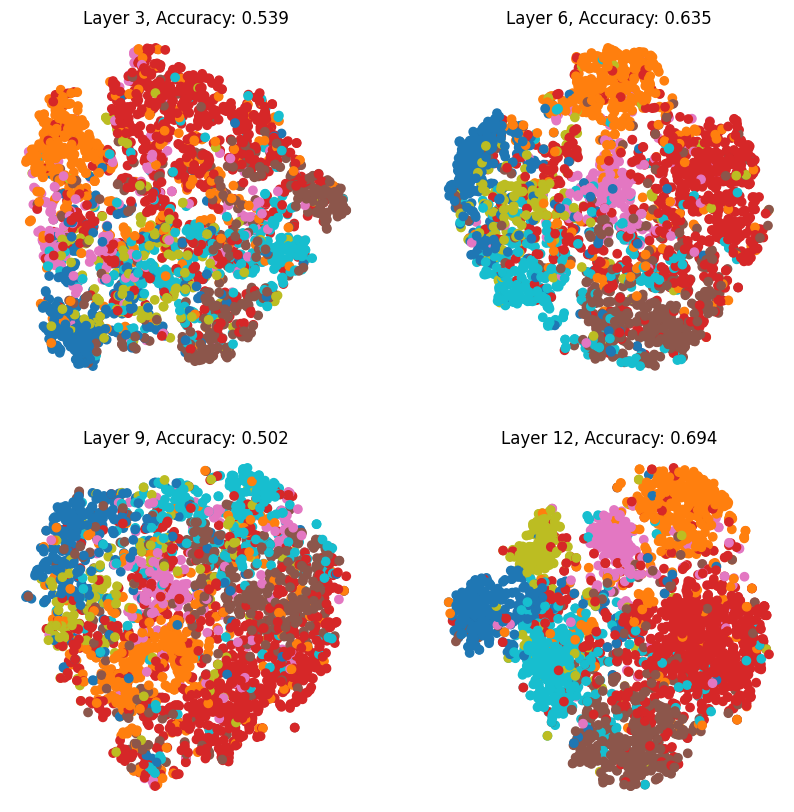

In [10]:
# plot the embeddings
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ((layer, (TSNE_embedding, labels, accuracy)), ax) in enumerate(zip(TSNE_embeddings.items(), axs.flatten())):
    ax.scatter(TSNE_embedding[:, 0], TSNE_embedding[:, 1], c=labels, cmap='tab10')
    ax.set_title(f'Layer {layer}, Accuracy: {accuracy:.3f}')
    ax.axis('off')
plt.show()
